In [1]:
import pandas as pd
import numpy as np

In [2]:
hap16 = pd.read_csv("Data/2016.csv", index_col=0)
hap15 = pd.read_csv("Data/2015.csv", index_col=0)
suicide = pd.read_csv("Data/data.csv", header=1, index_col=0)

both = suicide[suicide.Sex == 'Both sexes']
male = suicide[suicide.Sex == 'Male']
female = suicide[suicide.Sex == 'Female']

b16 = both.drop(['Sex', '2015', '2010', '2005', '2000'], axis=1)
m16 = male.drop(['Sex', '2015', '2010', '2005', '2000'], axis=1)
f16 = female.drop(['Sex', '2015', '2010', '2005', '2000'], axis=1)
b15 = both.drop(['Sex', '2016', '2010', '2005', '2000'], axis=1)
m15 = male.drop(['Sex', '2016', '2010', '2005', '2000'], axis=1)
f15 = female.drop(['Sex', '2016', '2010', '2005', '2000'], axis=1)

df16 = hap16.join(b16, how='inner')
df15 = hap15.join(b15, how='inner')

df16 = df16.rename(columns={'2016':'Suicide Rate'})
df15 = df15.rename(columns={'2015':'Suicide Rate'})

In [11]:
df16.head()

,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Suicide Rate
Country,,,,,,,,,,,,,
Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,12.8
Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,17.2
Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,14.0
Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,12.2
Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,15.9


## Models for Making Predictions

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score
import math
from matplotlib import pyplot as plt

Here we split the data into a training set and testing set. We are using the happiness data to make predictions about the suicide rate.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df16.drop(columns=['Suicide Rate', 'Region', 'Happiness Rank']), df16['Suicide Rate'], test_size=0.3, random_state=142)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(93, 10) (40, 10) (93,) (40,)


## Linear Regression

The first model explored is Linear Regression. As this is a fairly simple model we were not expecting good results as the data had no obvious correlations and therefore a linear model would not be able to make any accurate predictions.

In [55]:
# Fitting the Model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Prediciting suicide rate given Happiness data
y_pred = model.predict(X_test)

# Scoring the prediction
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("MSE:", mse)
print("R Squared:", r2)
print("MAE:", mae)

y = x * [-7.62287640e+14  3.81143820e+14  3.81143820e+14 -1.56676640e+03
 -1.55703631e+03 -1.57006345e+03 -1.56748821e+03 -1.56879607e+03
 -1.57040939e+03 -1.56749448e+03] + 1.3559125245415196
RMSE: 29.757933222094294
R Squared: -0.08961136086960009
MAE: 4.5055051787441345


Text(0.5,1,'Happiness Score Vs Suicide Rates: Decision Tree Predictions')

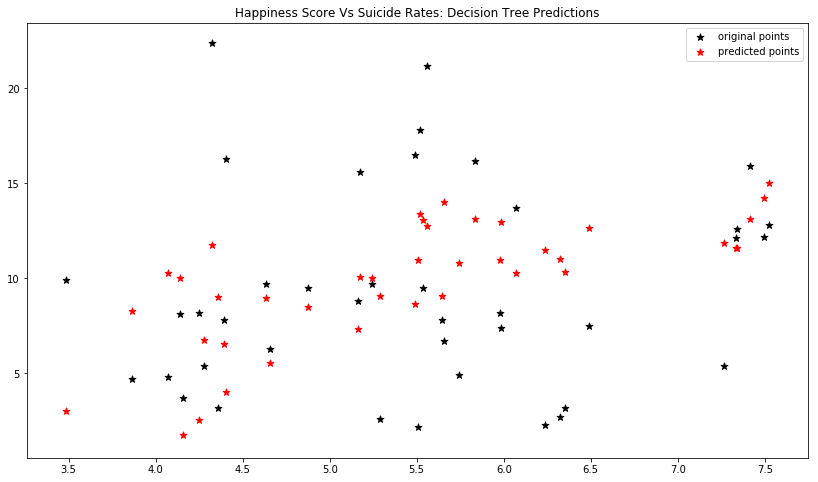

In [56]:
plt.figure(figsize=(14,8))
plt.scatter(X_test['Happiness Score'], y_test, marker='*', c='k', s=50, label='original points')
plt.scatter(X_test['Happiness Score'], y_pred, marker='*', c='r', s=50, label='predicted points')
plt.legend()
plt.title('Happiness Score Vs Suicide Rates: Decision Tree Predictions')

As shown in the results and graph above, linear regression performed poorly. On average the mean squared error was 29.75 which is significantly large given the mean rate of suicide. The negative R squared value tells us that the model fits worse than horizontal line. 

In [21]:
from sklearn.feature_selection import RFE

# Selecting the best features
estimator = linear_model.LinearRegression()
selector = RFE(estimator, 6, step=1)
selector.fit(X_train, y_train)
y_predict = selector.predict(X_test)

colNames = X_train.columns
print("Important features: ", colNames[selector.support_])

Important features:  Index(['Happiness Score', 'Lower Confidence Interval',
       'Upper Confidence Interval', 'Health (Life Expectancy)',
       'Trust (Government Corruption)', 'Generosity'],
      dtype='object')


The RFE estimator tells us that using a linear model the most important features were Happiness Score', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Health (Life Expectancy)', 'Trust (Government Corruption)', 'Generosity' when looking at the top 6 features.

In [22]:
X_scale_train = pd.DataFrame()
X_scale_test = pd.DataFrame()

rmse_set = []
r2_set = []
mae_set = []

for col in X_train:
    model = linear_model.LinearRegression()
    
    X_scale_train[col] = X_train[col]
    X_scale_test[col] = X_test[col]
    
    model.fit(X_scale_train, y_train)

    y_pred_scale = model.predict(X_scale_test)
    rmse_set.append(math.sqrt(mean_squared_error(y_test, y_pred_scale)))
    r2_set.append(r2_score(y_test, y_pred_scale))
    mae_set.append(mean_absolute_error(y_test, y_pred_scale))

Text(0,0.5,'RMSE')

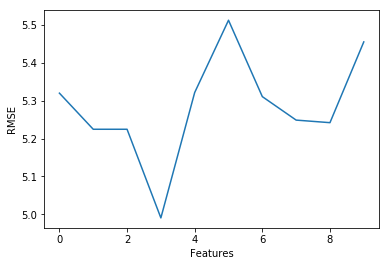

In [23]:
plt.plot(rmse_set)
plt.xlabel("Features")
plt.ylabel("RMSE")

The graph above shows the performance of linear regression as more features are added. As shown the best performance is reached at 3 features.

## MLP Regressor 

The next model used was the Multi-layer Perceptron Regressor. We had hoped that this model, which is more complicated than linear regression, would be able to perform better on the data. 

In [35]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=0, max_iter=600)
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [58]:
y_cap = mlp.predict(X_test)
mlp_mse = mean_squared_error(y_test, y_cap)
mlp_r2 = r2_score(y_test, y_cap)

print('MSE: ', mlp_mse, 'r2: ', mlp_r2)

MSE:  28.543775698546504 r2:  -0.04515397797041687


Unfortunatly its performance was only slighly better than linear regression.

Text(0.5,1,'Happiness Score Vs Suicide Rates: MLP Regressor Predictions')

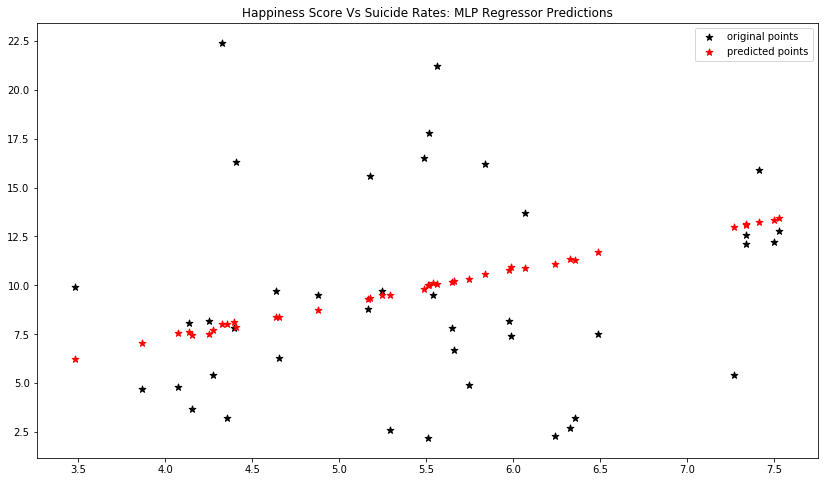

In [51]:
plt.figure(figsize=(14,8))
plt.scatter(X_test['Happiness Score'], y_test, marker='*', c='k', s=50, label='original points')
plt.scatter(X_test['Happiness Score'], y_cap, marker='*', c='r', s=50, label='predicted points')
plt.legend()
plt.title('Happiness Score Vs Suicide Rates: MLP Regressor Predictions')

## Decision Trees

In [52]:
from sklearn.tree import DecisionTreeRegressor

# Initialising and fitting the regressor
regressor = DecisionTreeRegressor(random_state=0, max_depth=8)
regressor.fit(X_train, y_train)
y_cap_tree = regressor.predict(X_test)

In [53]:
tree_mse = mean_squared_error(y_test, y_cap_tree)
tree_r2 = r2_score(y_test, y_cap_tree)

print('MSE: ', tree_mse, 'r2: ', tree_r2)

MSE:  30.33988920734714 r2:  -0.11092016105827596


The Decision Tree Algorithm performed worst, with an MSE of 30.34. 

Text(0.5,1,'Happiness Score Vs Suicide Rates: Decision Tree Predictions')

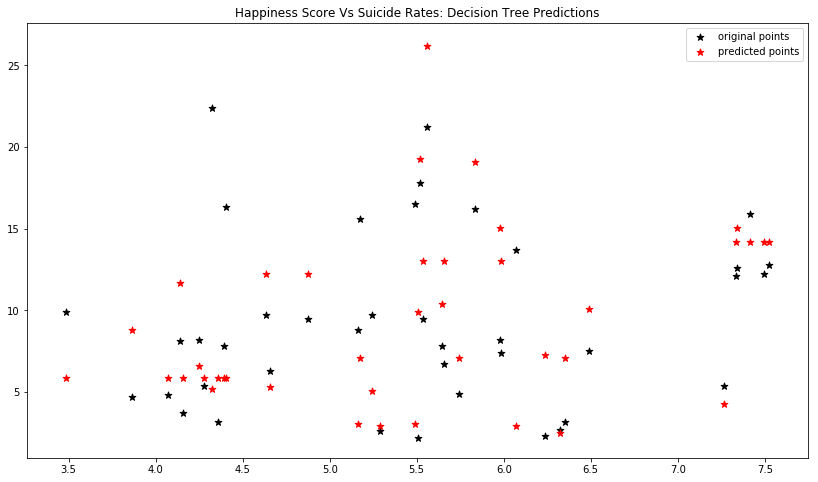

In [54]:
plt.figure(figsize=(14,8))
plt.scatter(X_test['Happiness Score'], y_test, marker='*', c='k', s=50, label='original points')
plt.scatter(X_test['Happiness Score'], y_cap_tree, marker='*', c='r', s=50, label='predicted points')
plt.legend()
plt.title('Happiness Score Vs Suicide Rates: Decision Tree Predictions')

In [77]:
mse_data = []
mse_data.append(mse)
mse_data.append(mlp_mse)
mse_data.append(tree_mse)

r2_data = []
r2_data.append(r2)
r2_data.append(mlp_r2)
r2_data.append(tree_r2)

<function matplotlib.pyplot.show(*args, **kw)>

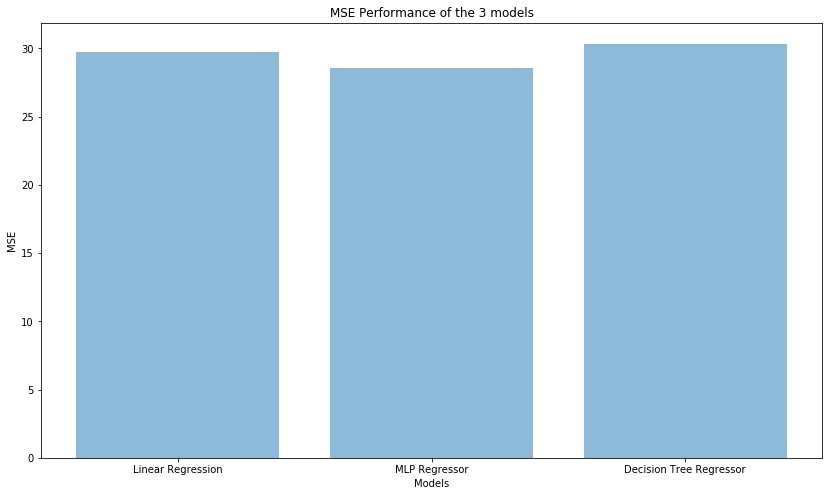

In [90]:
labels = ['Linear Regression', 'MLP Regressor', 'Decision Tree Regressor']

plt.figure(figsize=(14,8))
plt.bar(np.arange(len(mse_data)), mse_data, align='center', alpha=0.5)
plt.xticks(np.arange(len(mse_data)), labels)
plt.ylabel('MSE')
plt.xlabel('Models')
plt.title('MSE Performance of the 3 models')
plt.show

The performance of all 3 models is very similar.

<function matplotlib.pyplot.show(*args, **kw)>

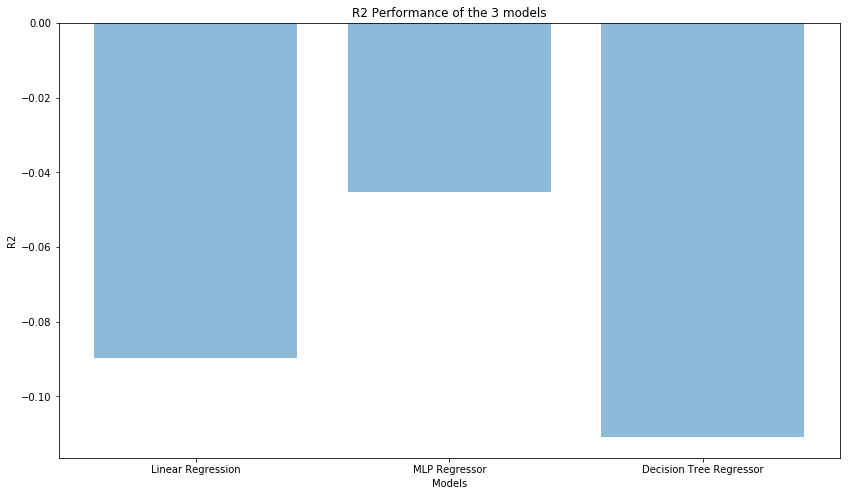

In [88]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(len(r2_data)), r2_data, align='center', alpha=0.5)
plt.xticks(np.arange(len(r2_data)), labels)
plt.ylabel('R2')
plt.xlabel('Models')
plt.title('R2 Performance of the 3 models')
plt.show

All 3 models have a negative R squared. This indicates that a horizontal line is a better predictor on the data then the models. From the results we can conclude that there is no correlation between a countries happiness score and its suicide rate. 